In [10]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from sklearn.metrics import classification_report

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into a DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'colon_aca': 'Colon_adenocarcinoma', 'colon_n': 'Colon_benign_tissue'}


    df[column_name] = df[column_name].replace(index)

In [12]:
# loading the data
data_dir = '/content/drive/MyDrive/مشروع تخرج تست/dataset'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

,filepaths,labels
0,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_adenocarcinoma
1,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_adenocarcinoma
2,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_adenocarcinoma
3,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_adenocarcinoma
4,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_adenocarcinoma
...,...,...
10045,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_benign_tissue
10046,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_benign_tissue
10047,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_benign_tissue
10048,/content/drive/MyDrive/مشروع تخرج تست/dataset/...,Colon_benign_tissue


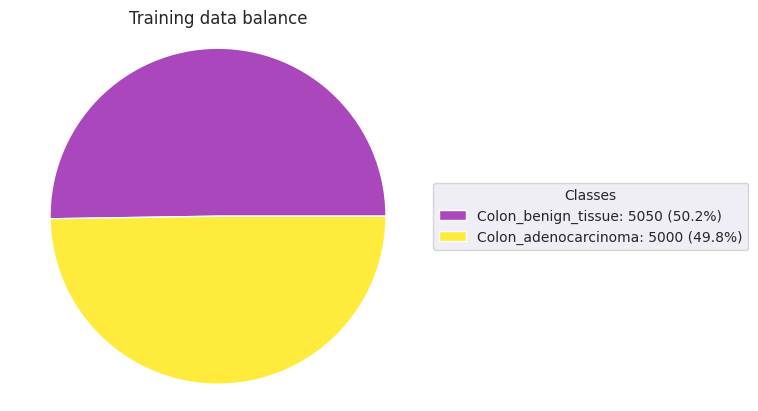

In [16]:
import matplotlib.pyplot as plt

data_balance = df.labels.value_counts()

# Darker shades of purple and yellow
colors = ["#ab47bc", "#ffeb3b"]

# Plot pie chart without labels and values on the chart
fig, ax = plt.subplots()
wedges, _ = ax.pie(data_balance, colors=colors)

# Legend with labels and colors
legend_labels = [f"{label}: {value} ({value/sum(data_balance)*100:.1f}%)" for label, value in zip(data_balance.index, data_balance)]
ax.legend(wedges, legend_labels, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Training data balance")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adjust the plot size to fit the legend
plt.subplots_adjust(left=0.1, right=0.75)
plt.show()


In [ ]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8040 validated image filenames belonging to 2 classes.
Found 1005 validated image filenames belonging to 2 classes.
Found 1005 validated image filenames belonging to 2 classes.


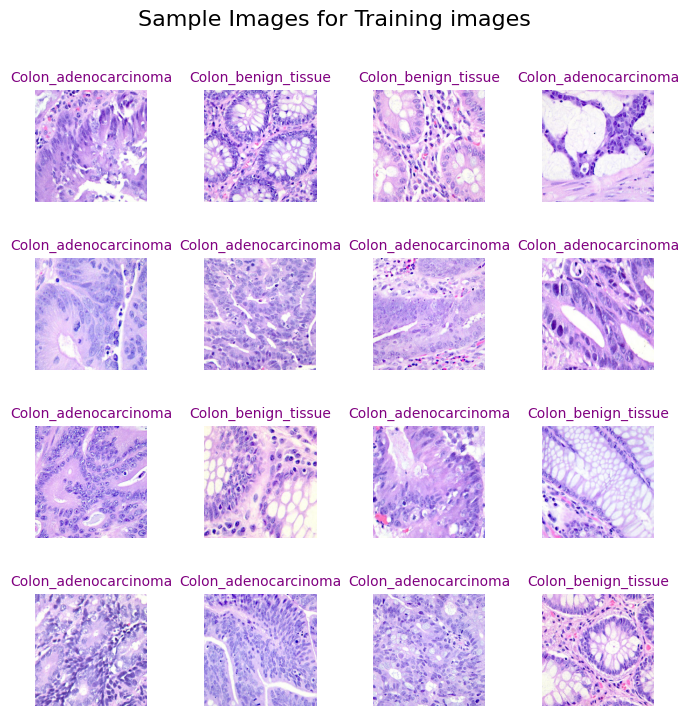

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

# Adjust the figure size and spacing
plt.figure(figsize=(8, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

batch_size = len(images)

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='purple', fontsize=10)  # Change the color to purple
    plt.axis('off')

plt.suptitle("Sample Images for Training images", fontsize=16, color='black')
plt.show()


In [ ]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])


# Get Predictions
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):

    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [ ]:
# create Model structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [ ]:
# Model architecture
cnn_model = Sequential()

# first conv block
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

# second conv block
cnn_model.add(conv_block(32))

# third conv block
cnn_model.add(conv_block(64))

# fourth conv bolck
cnn_model.add(conv_block(128))

# fifth conv block
cnn_model.add(conv_block(256))

# flatten layer
cnn_model.add(Flatten())

# first dense block
cnn_model.add(dense_block(128, 0.5))

# second dense block
cnn_model.add(dense_block(64, 0.3))

# third dense block
cnn_model.add(dense_block(32, 0.2))

# output layer
cnn_model.add(Dense(class_counts, activation = "sigmoid"))

CNN Model

In [ ]:
cnn_model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 32)        14016     
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 64)        55680     
                                                                 
 sequential_3 (Sequential)   (None, 14, 14, 128)       2

In [ ]:
# train the model
epochs = 5  # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/5
503/503 [==============================] - 1946s 4s/step - loss: 0.3181 - accuracy: 0.8757 - val_loss: 4.8771 - val_accuracy: 0.5045
Epoch 2/5
503/503 [==============================] - 75s 149ms/step - loss: 0.1315 - accuracy: 0.9580 - val_loss: 0.0259 - val_accuracy: 0.9970
Epoch 3/5
503/503 [==============================] - 74s 146ms/step - loss: 0.1032 - accuracy: 0.9670 - val_loss: 0.2924 - val_accuracy: 0.8667
Epoch 4/5
503/503 [==============================] - 74s 147ms/step - loss: 0.0765 - accuracy: 0.9770 - val_loss: 0.1370 - val_accuracy: 0.9532
Epoch 5/5
503/503 [==============================] - 71s 141ms/step - loss: 0.0805 - accuracy: 0.9748 - val_loss: 0.2120 - val_accuracy: 0.9144


In [ ]:
# train the model
epochs = 10   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
503/503 [==============================] - 72s 143ms/step - loss: 0.0550 - accuracy: 0.9837 - val_loss: 0.0179 - val_accuracy: 0.9950
Epoch 2/10
503/503 [==============================] - 71s 140ms/step - loss: 0.0602 - accuracy: 0.9810 - val_loss: 0.0195 - val_accuracy: 0.9960
Epoch 3/10
503/503 [==============================] - 75s 149ms/step - loss: 0.0398 - accuracy: 0.9888 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 4/10
503/503 [==============================] - 72s 143ms/step - loss: 0.0447 - accuracy: 0.9866 - val_loss: 0.0167 - val_accuracy: 0.9940
Epoch 5/10
503/503 [==============================] - 72s 144ms/step - loss: 0.0351 - accuracy: 0.9900 - val_loss: 0.0057 - val_accuracy: 0.9980
Epoch 6/10
503/503 [==============================] - 72s 144ms/step - loss: 0.0298 - accuracy: 0.9907 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/10
503/503 [==============================] - 71s 142ms/step - loss: 0.0462 - accuracy: 0.9878 - val_loss: 1.7175 - val_ac

In [ ]:
# train the model
epochs = 20   # number of all epochs in training

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
503/503 [==============================] - 82s 162ms/step - loss: 0.0139 - accuracy: 0.9965 - val_loss: 7.1461e-04 - val_accuracy: 1.0000
Epoch 2/20
503/503 [==============================] - 73s 145ms/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 1.3949e-04 - val_accuracy: 1.0000
Epoch 3/20
503/503 [==============================] - 72s 142ms/step - loss: 0.0097 - accuracy: 0.9979 - val_loss: 1.2975e-04 - val_accuracy: 1.0000
Epoch 4/20
503/503 [==============================] - 72s 142ms/step - loss: 0.0122 - accuracy: 0.9968 - val_loss: 1.5199e-04 - val_accuracy: 1.0000
Epoch 5/20
503/503 [==============================] - 70s 139ms/step - loss: 0.0109 - accuracy: 0.9968 - val_loss: 0.0060 - val_accuracy: 0.9970
Epoch 6/20
503/503 [==============================] - 71s 142ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.0050 - val_accuracy: 0.9980
Epoch 7/20
503/503 [==============================] - 72s 144ms/step - loss: 0.0137 - accuracy: 0.9966 - val_loss:

In [ ]:

# Get predictions
y_pred = cnn_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_gen.classes

# Generate classification report
report = classification_report(true_classes, y_pred_classes, target_names=test_gen.class_indices)

# Print the classification report
print(report)


63/63 [==============================] - 218s 4s/step
                      precision    recall  f1-score   support

Colon_adenocarcinoma       1.00      1.00      1.00       495
 Colon_benign_tissue       1.00      1.00      1.00       510

            accuracy                           1.00      1005
           macro avg       1.00      1.00      1.00      1005
        weighted avg       1.00      1.00      1.00      1005



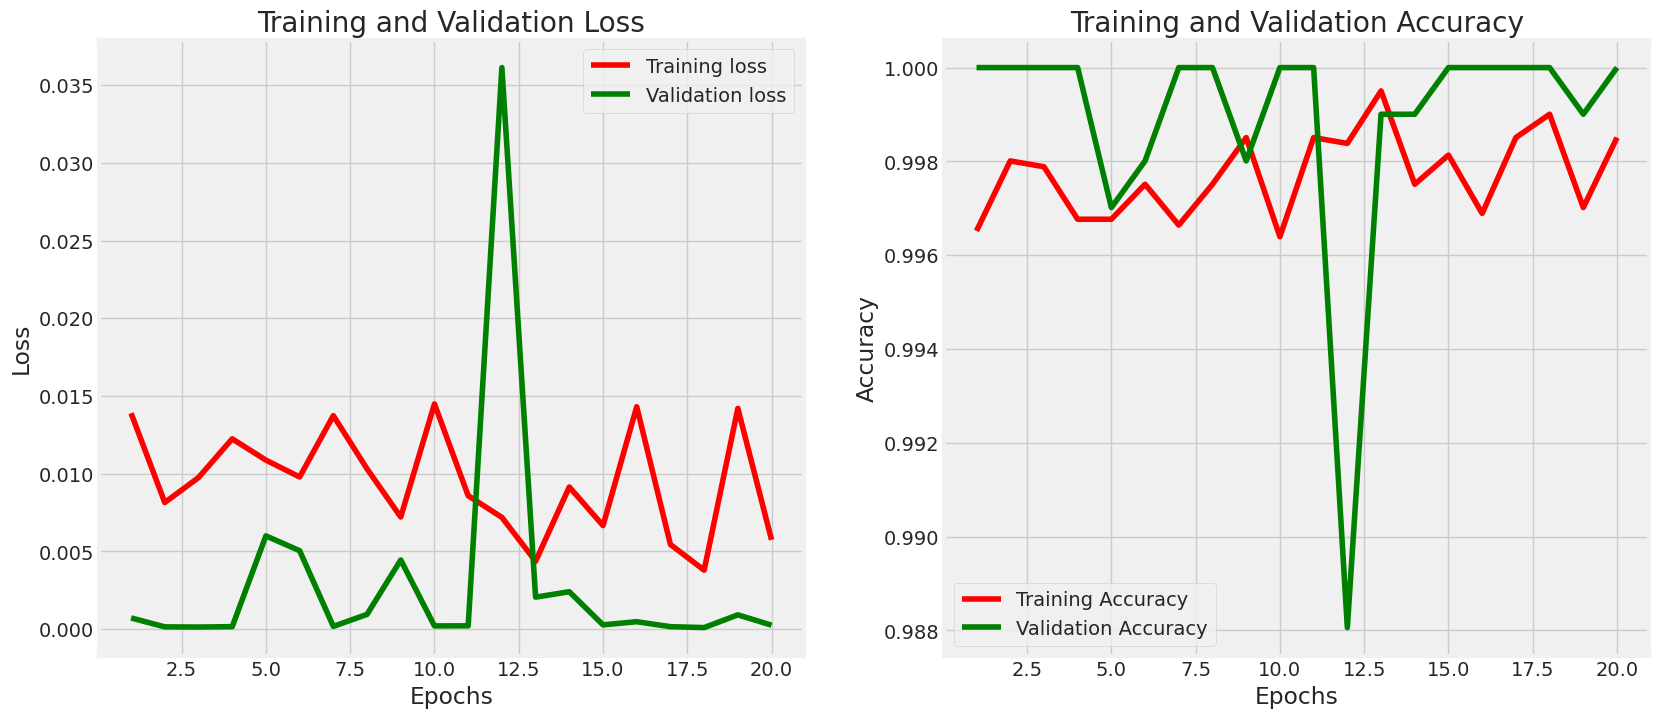

In [ ]:
# Display model performance
model_performance(history, epochs)


In [ ]:
# Model evaluation
model_evaluation(cnn_model)

63/63 [==============================] - 8s 124ms/step - loss: 3.4024e-04 - accuracy: 1.0000
Train Loss:  0.00012190339475637302
Train Accuracy:  1.0
--------------------
Validation Loss:  0.000250230630626902
Validation Accuracy:  1.0
--------------------
Test Loss:  0.0003402362344786525
Test Accuracy:  1.0


63/63 [==============================] - 7s 112ms/step


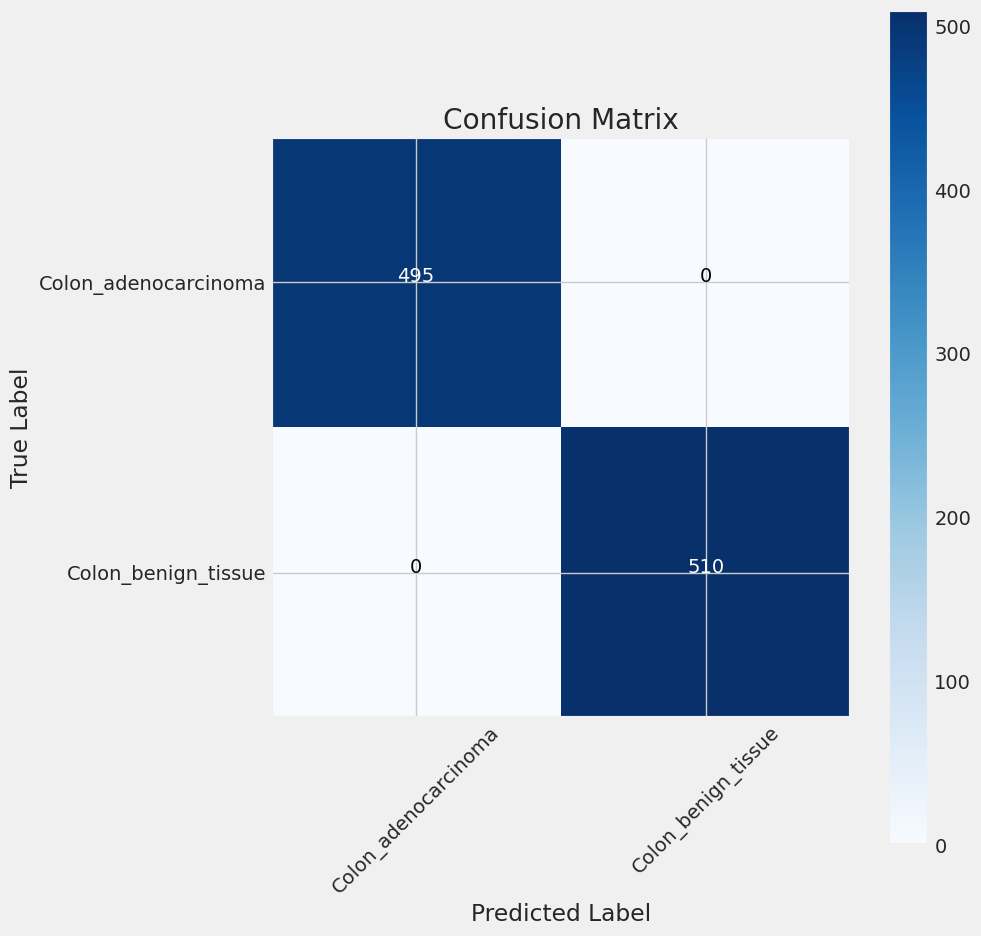

In [ ]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

**EfficentNetB3**

In [ ]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
# train the model
epochs = 20   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
503/503 [==============================] - 216s 310ms/step - loss: 0.3394 - accuracy: 0.9080 - val_loss: 0.5917 - val_accuracy: 0.6149
Epoch 2/20
503/503 [==============================] - 147s 292ms/step - loss: 0.1653 - accuracy: 0.9680 - val_loss: 0.0751 - val_accuracy: 0.9990
Epoch 3/20
503/503 [==============================] - 147s 292ms/step - loss: 0.1135 - accuracy: 0.9779 - val_loss: 0.1065 - val_accuracy: 0.9871
Epoch 4/20
503/503 [==============================] - 147s 292ms/step - loss: 0.0807 - accuracy: 0.9876 - val_loss: 0.0280 - val_accuracy: 1.0000
Epoch 5/20
503/503 [==============================] - 148s 294ms/step - loss: 0.0631 - accuracy: 0.9897 - val_loss: 0.0215 - val_accuracy: 1.0000
Epoch 6/20
503/503 [==============================] - 147s 293ms/step - loss: 0.0510 - accuracy: 0.9917 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 7/20
503/503 [==============================] - 149s 296ms/step - loss: 0.0468 - accuracy: 0.9912 - val_loss: 0.0115 -

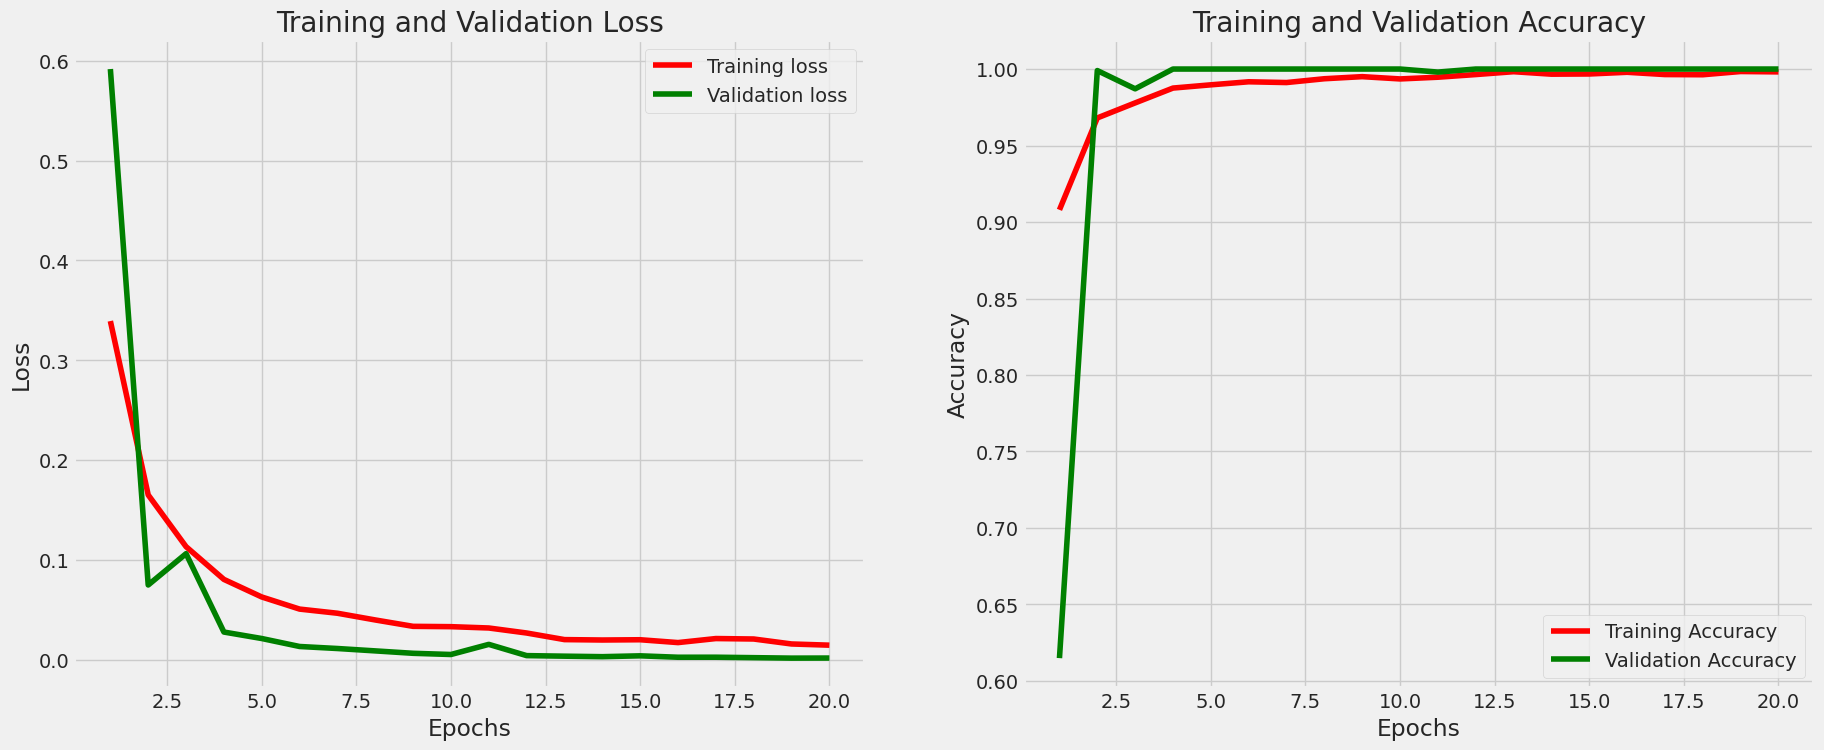

In [ ]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)

In [ ]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

63/63 [==============================] - 8s 127ms/step - loss: 0.0020 - accuracy: 1.0000
Train Loss:  0.0019550707656890154
Train Accuracy:  1.0
--------------------
Validation Loss:  0.001970837824046612
Validation Accuracy:  1.0
--------------------
Test Loss:  0.001995240803807974
Test Accuracy:  1.0


In [ ]:

# Get predictions
y_pred = EfficientNetB3_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_gen.classes

# Generate classification report
report = classification_report(true_classes, y_pred_classes, target_names=test_gen.class_indices)

# Print the classification report
print(report)


63/63 [==============================] - 11s 123ms/step
                      precision    recall  f1-score   support

Colon_adenocarcinoma       1.00      1.00      1.00       495
 Colon_benign_tissue       1.00      1.00      1.00       510

            accuracy                           1.00      1005
           macro avg       1.00      1.00      1.00      1005
        weighted avg       1.00      1.00      1.00      1005



63/63 [==============================] - 8s 134ms/step


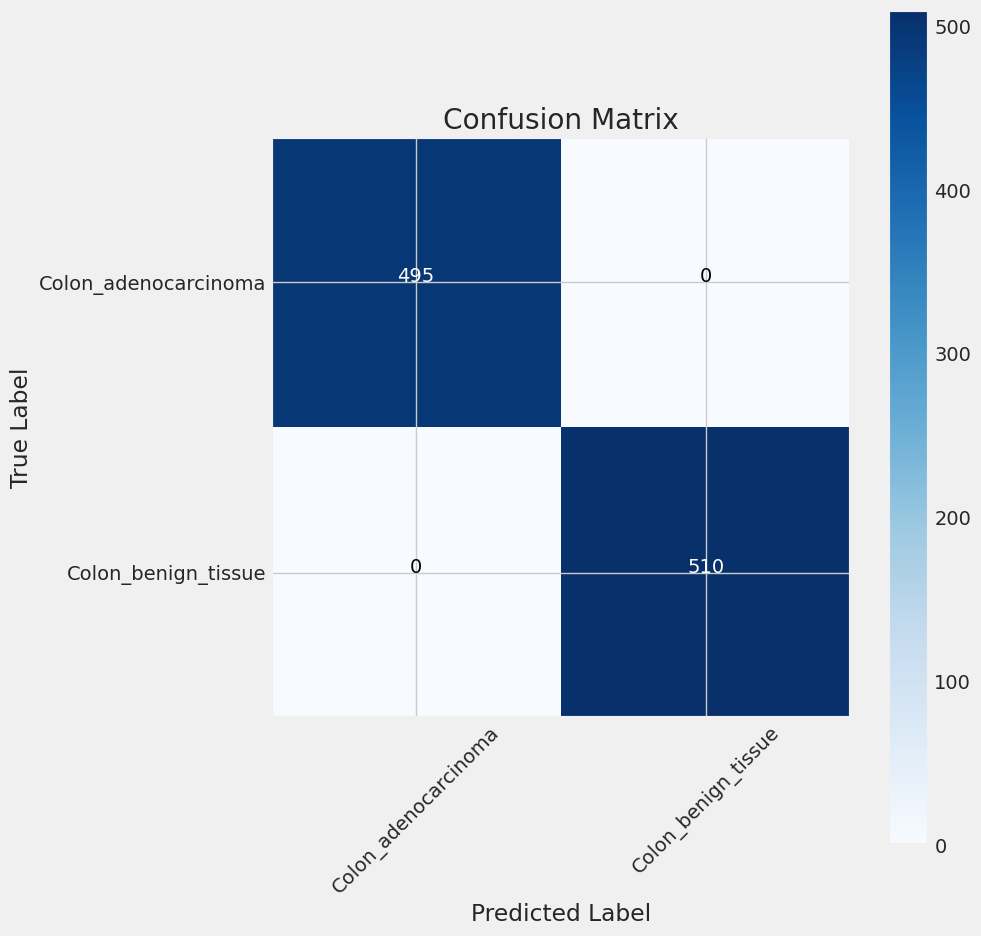

In [ ]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)